## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
import keras
import keras.utils

## Loading the dataset

In [5]:
data_dir = pathlib.Path('data')

In [6]:
train_path = 'output_ori/train'
valid_path = 'output_ori/test'

In [7]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

2515


There are a total of 2515 images in the dataset

## Displaying a few images

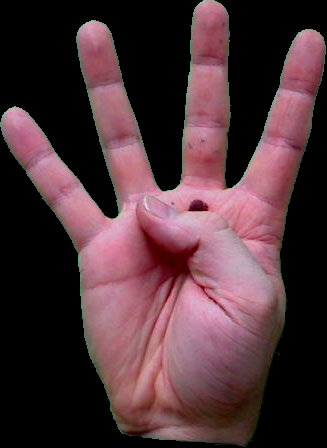

In [8]:
four = list(data_dir.glob('4/*'))
PIL.Image.open(str(four[0]))

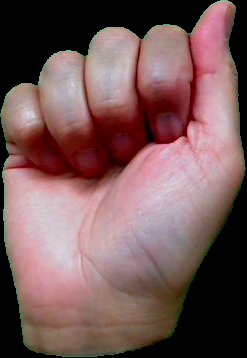

In [9]:
a = list(data_dir.glob('a/*'))
PIL.Image.open(str(a[0]))

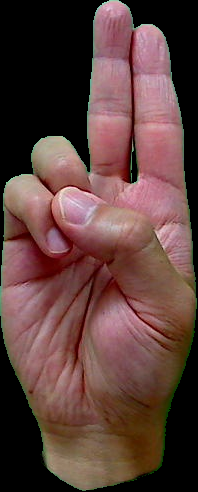

In [10]:
u = list(data_dir.glob('u/*'))
PIL.Image.open(str(u[0]))

### Defining parameters

In [11]:
batch_size = 32
img_height = 224
img_width = 224

## Splitting the dataset (80/20)

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  validation_split=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [12]:
class_names = train_path.class_names
print(class_names)

AttributeError: 'str' object has no attribute 'class_names'

## Visualise the data

First 9 images in the training dataset

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Retrieve batches of images

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

Batch of 32 images of shape (224,224,3)

### Configure the dataset for performance

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardise the data

Standardise values to be in the `[0, 1]` range

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[7]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

## Creating the model

In [ ]:
num_classes = len(class_names)
IMAGE_SIZE = [img_height, img_width]

vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# Not training the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False
    
x = Flatten()(vgg.output)
prediction = Dense(36, activation='softmax')(x) # softmax is used as it is a multiclass classification
model = Model(inputs=vgg.input, outputs=prediction)

### Model Summary

View the structure of the model

In [ ]:
model.summary()

### Compile the model

In [ ]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

### Train the model

In [ ]:
epochs=10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

## Visualise training results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# train_ds = train_datagen.flow_from_directory(train_dir,
#                                              target_size = (224, 224),
#                                              batch_size = 32,
#                                              class_mode = 'sparse')

train_datagen.fit(train_ds)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
class_names = train_ds.class_names
print(class_names)